# lineart test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from flat import rgba, font, shape, strike, document
from IPython.display import Image
import dask

from lineart.shapes import Octahedron
from lineart.transforms import rotate, rotate_xy, sample_line, add_z_jitter
import lineart.style as style

## First experiment

In [3]:
image_size = 100

In [7]:
# colors
canvas = rgba(254, 250, 219, 255)
sand = rgba(254, 250, 219, 50)
blue = rgba(33, 80, 98, 255)
red = rgba(255, 0, 0, 255)
# styles
background = shape().fill(blue).nostroke()
netstyle = shape().stroke(canvas).width(1)
sandstyle = shape().fill(sand).nostroke()
debug = shape().stroke(red).width(0.5)

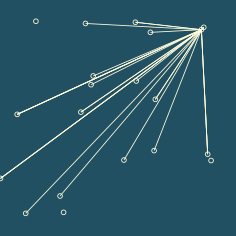

In [5]:
# page setup
d = document(image_size, image_size, "mm")
page = d.addpage()
page.place(background.rectangle(0, 0, image_size, image_size))

nodes = np.random.rand(20, 2) * image_size

for p in nodes:
    page.place(netstyle.circle(*p, 1))
for i in range(30):
    page.place(netstyle.line(*nodes[0], *nodes[np.random.randint(len(nodes))]))

# Display image
Image((page.image(kind="rgba", ppi=60).png()))

## single line dither test

3D rotation about some normalised vector u

\begin{bmatrix}\cos \theta +u_{x}^{2}\left(1-\cos \theta \right)&u_{x}u_{y}\left(1-\cos \theta \right)-u_{z}\sin \theta &u_{x}u_{z}\left(1-\cos \theta \right)+u_{y}\sin \theta \\u_{y}u_{x}\left(1-\cos \theta \right)+u_{z}\sin \theta &\cos \theta +u_{y}^{2}\left(1-\cos \theta \right)&u_{y}u_{z}\left(1-\cos \theta \right)-u_{x}\sin \theta \\u_{z}u_{x}\left(1-\cos \theta \right)-u_{y}\sin \theta &u_{z}u_{y}\left(1-\cos \theta \right)+u_{x}\sin \theta &\cos \theta +u_{z}^{2}\left(1-\cos \theta \right)\end{bmatrix}

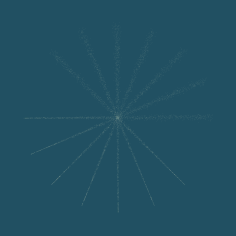

In [6]:
image_size = 100
# page setup
d = document(image_size, image_size, "mm")
page = d.addpage()
page.place(background.rectangle(0, 0, image_size, image_size))


nodes = np.array([[10, 50, 0], [90, 50, 100]])

rotation_point = np.array([50, 50, 0])
for i in range(7):
    theta = np.pi / 8

    # page.place(netstyle.circle(*dither_line.p1[:2], 1))
    # page.place(netstyle.circle(*dither_line.p2[:2], 1))
    # page.place(debug.line(*dither_line.p1,*dither_line.p2))
    samples = add_z_jitter(sample_line(*nodes, 1000), 0.004)

    for p in samples:
        page.place(sandstyle.circle(*p[:2], 0.1))
    nodes = rotate_xy(nodes, rotation_point, theta)
# Display image
Image((page.image(kind="rgba", ppi=60).png()))

### Polygon test

#### Examination of rendering time for sampled polyhedra

In [82]:
%%time
image_size = 100
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))
o = Octahedron(np.array([50,50,40]),40)

o.rotate([50,50,40], [1,1,1], np.pi*2/16)





CPU times: user 26 ms, sys: 2.04 ms, total: 28 ms
Wall time: 27.7 ms


In [83]:
%%time
# linear with number of samples
samples = o.sample(2000, 0.01)

CPU times: user 4.02 ms, sys: 1.09 ms, total: 5.11 ms
Wall time: 4.38 ms


In [84]:
samples.shape

(24000, 3)

In [85]:
%%time
# slightly more than linear with number of samples
for p in samples:
    page.place(sandstyle.circle(*p[:2], 0.1))
# Display image

CPU times: user 64.8 ms, sys: 1.49 ms, total: 66.3 ms
Wall time: 65.6 ms


CPU times: user 2.18 s, sys: 1.95 ms, total: 2.18 s
Wall time: 2.18 s


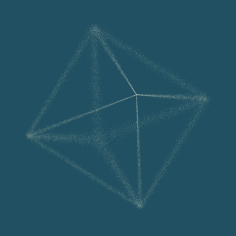

In [86]:
%%time
# linear with number of samples
Image((page.image(kind="rgba", ppi=60).png()))

#### Dask delayed multiprocessing rendering of rotating image

In [16]:
@dask.delayed
def sample_octohedron(i):
    image_size = 100
    # page setup
    d = document(image_size, image_size, "mm")
    page = d.addpage()
    page.place(background.rectangle(0, 0, image_size, image_size))
    o = Octahedron(np.array([50, 50, 40]), 40)

    o.rotate([50, 50, 40], [1, 1, 1], np.pi * 2 / 200 * i)
    samples = o.sample(1000, 0.03)

    for p in samples:
        page.place(sandstyle.circle(*p[:2], 0.1))
    # Display image
    page.image(kind="rgba", ppi=60).png(f"outputs/{i:03d}.png")
    return i


samples = [sample_octohedron(i) for i in range(20)]

In [17]:
%%time
dask.persist(*samples, scheduler="processes")

CPU times: user 46.8 ms, sys: 46.7 ms, total: 93.5 ms
Wall time: 4.75 s


(Delayed('sample_octohedron-3b8c91d1-4c87-4508-8163-125a61d7db13'),
 Delayed('sample_octohedron-ec02af17-a91c-4c73-9bcf-39217b8c90d1'),
 Delayed('sample_octohedron-80322099-b5e2-4451-b0cd-61f7c20d6afb'),
 Delayed('sample_octohedron-5d48db4d-6eea-4f76-9b13-034b737e9d0c'),
 Delayed('sample_octohedron-73c15a7d-1b00-4d01-a051-a924c43d2475'),
 Delayed('sample_octohedron-940b00a5-af1c-45a9-a20d-218b0734ad7c'),
 Delayed('sample_octohedron-57449064-547b-4641-9a1c-2db24909fdcd'),
 Delayed('sample_octohedron-93acb662-9c2e-43b6-b984-7a10e52c2cc7'),
 Delayed('sample_octohedron-dafd38a0-6b8a-43dc-a5f6-f03cc0caaa09'),
 Delayed('sample_octohedron-1e35f83a-72a4-48b9-86b6-eea1fdedd4b0'),
 Delayed('sample_octohedron-e46d5ec8-48ac-446d-8ba0-d72abc7ac134'),
 Delayed('sample_octohedron-fc0f6837-9ba5-4eac-b058-b68080cc6369'),
 Delayed('sample_octohedron-51805692-c1cd-47f4-9b17-4f0d47e21e2e'),
 Delayed('sample_octohedron-85dea84a-b0dc-4b96-aa35-3181adade067'),
 Delayed('sample_octohedron-89fe25c4-938f-4f6c-b

### Random network